<a href="https://colab.research.google.com/github/linlcc/MNIST/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digit Classification

In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

First we'll import Pytorch and also import some dependencies.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

## 1.1 MNIST dataset 

Let's download and load the dataset and display a few random samples from it:

In [2]:
# TODO: Define your transforms for the training, validation, and testing sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)),]
)

In [3]:
# TODO: Load the datasets with ImageFolder
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainLoader = dset.DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = dset.DataLoader(testSet, batch_size=64, shuffle=False)

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(trainLoader)
images, labels = dataiter.next()

print(images.shape,)
print(labels.shape,)

torch.Size([64, 1, 28, 28])
torch.Size([64])


Our training set is made up of 28x28 grayscale images of handwritten digits.

Let's visualize what some of these images and their corresponding training labels look like.

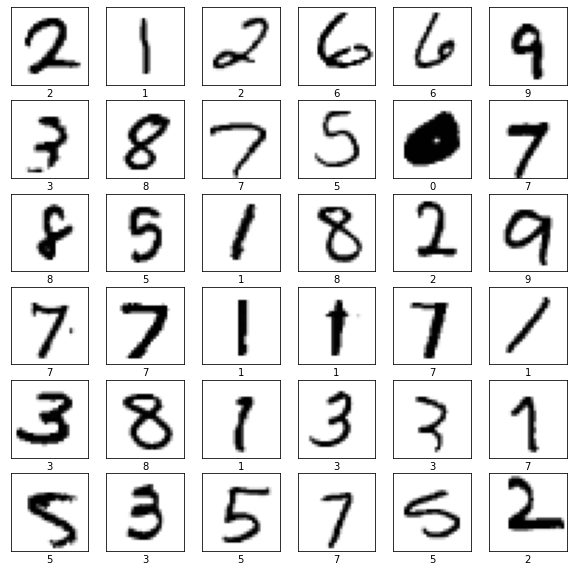

In [5]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(trainSet[image_ind][0]), cmap=plt.cm.binary)   
    plt.xlabel(trainSet[image_ind][1])

### 1.2 Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9).

### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll once again use the Pytorch API and define the model using the [`Sequential`] class. 

In this next block, you'll define the hidden layer and the output layer.

In [7]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [8]:
# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.main = nn.Sequential(
            # '''TODO: Define the first fully connected layer and the activation function.'''
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            # '''TODO: Define the second fully connected layer and the activation function.'''
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            # '''TODO: Define the output layer and output activation function to output the classification probabilities'''
            nn.Linear(in_features=64, out_features=10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)


net = Net().to(device)
print(net)

Net(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. 

Let's take a step back and think about the network we've just created. The first layer in this network transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up.

After the pixels are flattened, the network consists of a sequence of three layers. These are fully-connected neural layers. The first layer has 128 nodes (or neurons) and second layer has 64 nodes. The last layer should return an array of probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

### Compile the model

Before training the model, we need to define a few more settings. These are added during the model's [`compile`] step:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Validation* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a ADAM optimizer initialized with a learning rate of 0.001. Since we are performing a categorical classification task, we'll want to use the [cross entropy loss]

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model.

In [9]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()


In [10]:
# Measure the validation loss and accuracy
def validation(model, dataloader, loss_function, device):
    loss = 0.0
    accuracy = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):  
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.view(inputs.shape[0], -1)

            output = net(inputs)

            loss += loss_function(output, labels).item()

            ps = torch.exp(output) # get the class probabilities from log-softmax
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
    
    return loss, accuracy

### Train the model

We're now ready to train our model, which will involve feeding the training data (`trainLoader`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the number of epochs, or iterations over the MNIST dataset, to use during training.


In [11]:
epochs = 10
steps = 0.0
running_loss = 0.0
train_accuracy = 0.0
start = time.time()

for e in range(epochs):

    for i, data in enumerate(trainLoader):
        inputs, labels = data[0].to(device), data[1].to(device) # Move to GPU
        inputs = inputs.view(inputs.shape[0], -1)
        steps += 1

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        output = net(inputs)
        loss = loss_function(output, labels)

        # Backward
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Get the class probabilities from log-softmax
        ps = torch.exp(output) 
        equality = (labels.data == ps.max(dim=1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()

        if steps % len(trainLoader) == 0:
            # model.eval() # Validate in each epoch

            with torch.no_grad():
                valid_running_loss, valid_accuracy = validation(net, testLoader, loss_function, device)

            print("Epoch: {}/{} ".format(e+1, epochs),
                  "\nTraining Loss: {:.4f} ".format(running_loss/len(trainLoader)),
                  "Training Accuracy: {:.4f}".format(train_accuracy/len(trainLoader)),
                  "Validation Loss: {:.4f} ".format(valid_running_loss/len(testLoader)),
                  "Validation Accuracy: {:.4f}".format(valid_accuracy/len(testLoader)))

            running_loss = 0
            train_accuracy = 0
            # model.train() # Make sure training is back on

time_elapsed = time.time() - start            
print("Total time: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))


Epoch: 1/10  
Training Loss: 0.2629  Training Accuracy: 0.9211 Validation Loss: 0.1247  Validation Accuracy: 0.9614
Epoch: 2/10  
Training Loss: 0.1091  Training Accuracy: 0.9665 Validation Loss: 0.0943  Validation Accuracy: 0.9714
Epoch: 3/10  
Training Loss: 0.0769  Training Accuracy: 0.9755 Validation Loss: 0.0879  Validation Accuracy: 0.9720
Epoch: 4/10  
Training Loss: 0.0592  Training Accuracy: 0.9807 Validation Loss: 0.0839  Validation Accuracy: 0.9737
Epoch: 5/10  
Training Loss: 0.0479  Training Accuracy: 0.9844 Validation Loss: 0.0710  Validation Accuracy: 0.9782
Epoch: 6/10  
Training Loss: 0.0398  Training Accuracy: 0.9864 Validation Loss: 0.0880  Validation Accuracy: 0.9755
Epoch: 7/10  
Training Loss: 0.0343  Training Accuracy: 0.9888 Validation Loss: 0.0722  Validation Accuracy: 0.9795
Epoch: 8/10  
Training Loss: 0.0282  Training Accuracy: 0.9908 Validation Loss: 0.0938  Validation Accuracy: 0.9758
Epoch: 9/10  
Training Loss: 0.0271  Training Accuracy: 0.9908 Validatio

As the model trains, the loss and accuracy are displayed. With 10 epochs and a learning rate of 0.001, this fully connected model should achieve an accuracy of approximatley 0.97 (or 97%) on the training data.

### Testing the trained model
It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 95% accuracy on the test set if the model has been trained well.

In [12]:
# TODO: Do validation on the test set
with torch.no_grad():
    test_loss, test_accuracy = validation(net, testLoader, loss_function, device)
    
print("Testing Accuracy: {:.2f}%".format(100 * test_accuracy/len(testLoader)))

Testing Accuracy: 97.66%


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of overfitting, when a machine learning model performs worse on new data than on its training data.

### Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: testSet.class_to_idx. You can attach this to the model as an attribute which makes inference easier later on.

net.class_to_idx = testSet.class_to_idx

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, optimizer.state_dict. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
# TODO: Save the checkpoint
net.to('cpu')
net.class_to_idx =testSet.class_to_idx
checkpoint = {'input_size': 28*28*3,
              'output_size': 10,
              'model': net,
              'state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict,
              'criterion': loss_function,
              'epochs': epochs,
              'class_to_idx': net.class_to_idx
              }

torch.save(checkpoint, 'checkpoint.pth')


### Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model = checkpoint["model"]
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [15]:
net = load_checkpoint('checkpoint.pth')
net.to(device)

Net(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

### Class Prediction

It's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using class_to_idx which hopefully you added to the model or from an ImageFolder you used to load the data (see here). Make sure to invert the dictionary so you get a mapping from index to class as well.

In [16]:
def predict(topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    with torch.no_grad():
        All= next(iter(testLoader)) 
        data=All[0][62],All[1][62]
        inputs, labels = data[0].to(device), data[1].to(device)

        inputs = inputs.view(inputs.shape[0], -1)
        output = net(inputs)
        ps = torch.exp(output)
        probs, indices = torch.topk(ps, topk)
        probs = [float(prob) for prob in probs[0]]
        invert = {v: k for k, v in testSet.class_to_idx.items()}
        classes = [invert[int(index)] for index in indices[0]]


    return probs, classes

In [17]:
prob, classes = predict(topk=5)
print("prob: ", prob)
print("classes: ", classes)

prob:  [0.9976839423179626, 0.0012535549467429519, 0.0007522681844420731, 0.00029608793556690216, 6.91419381837477e-06]
classes:  ['9 - nine', '5 - five', '8 - eight', '4 - four', '7 - seven']


### Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use matplotlib to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

To show a PyTorch tensor as an image, use the imshow function defined above.

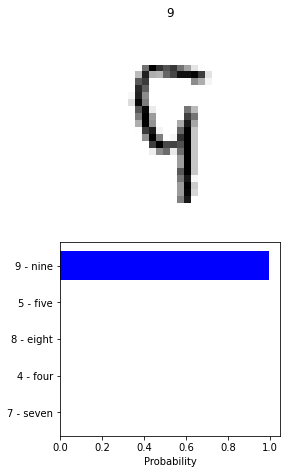

In [18]:
# TODO: Display an image along with the top 5 classes
max_index = np.argmax(prob)
max_probability = prob[max_index]
label = classes[max_index]
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((20,10), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((20,10), (10,2), colspan=5, rowspan=9)

All= next(iter(testLoader)) 
inputs=All[0][62]
labels=All[1][62]
ax1.axis('off')
ax1.set_title(labels.tolist())
ax1.imshow(inputs.numpy().squeeze(), cmap='gray_r')

labels = classes
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

plt.show()